## OCNT-DMSLIB-0-CRE DMS Assay Run #2: MC4R, Gs, Ipsen (DMS11)

| ID | Condition | Concentration | Replicates
| --- | ----------- | --- | ----------- |
| 1 | Forskolin | 2.5e-5 | 4 |
| 2 | None | 0 | 4 |
| 3 | aMSH | 1e-6 | 4 |
| 4 | Forskolin+Ipsen | 2.5e-5 | 4 |
| 5 | None+Ipsen | 4e-10 | 4 |
| 6 | aMSH+Ipsen | 1e-6 | 4 |

This report generates similar results to the full-length assay (DMS5) with aMSH and THIQ, but focused on identifying variants whose effect is mitigated or rescued by Ipsen treatment.

1. [Barcode Sequencing Distributions](#part1)
2. [Statistical Models of Chaperone Rescue](#part2)
3. [Visualizations](#part3)
4. [The "None" Condition](#part4)

In [2]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(ggbeeswarm)
library(colorspace)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [4]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-0-CRE-DMS11/mc4r-cre-chap-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "count", "lib", "chunk", "wt_aa", "pos",
                                        "mut_aa", "wt_codon", "mut_codon", "chunkID",
                                        "dox", "condition", "condition_conc","clone")) %>%
    group_by(sample) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           stop_counts = sum(count[which(mut_aa == "*")]),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

Rows: 10163559 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, chunkID, ...
dbl (5): count, chunk, pos, dox, condition_conc
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

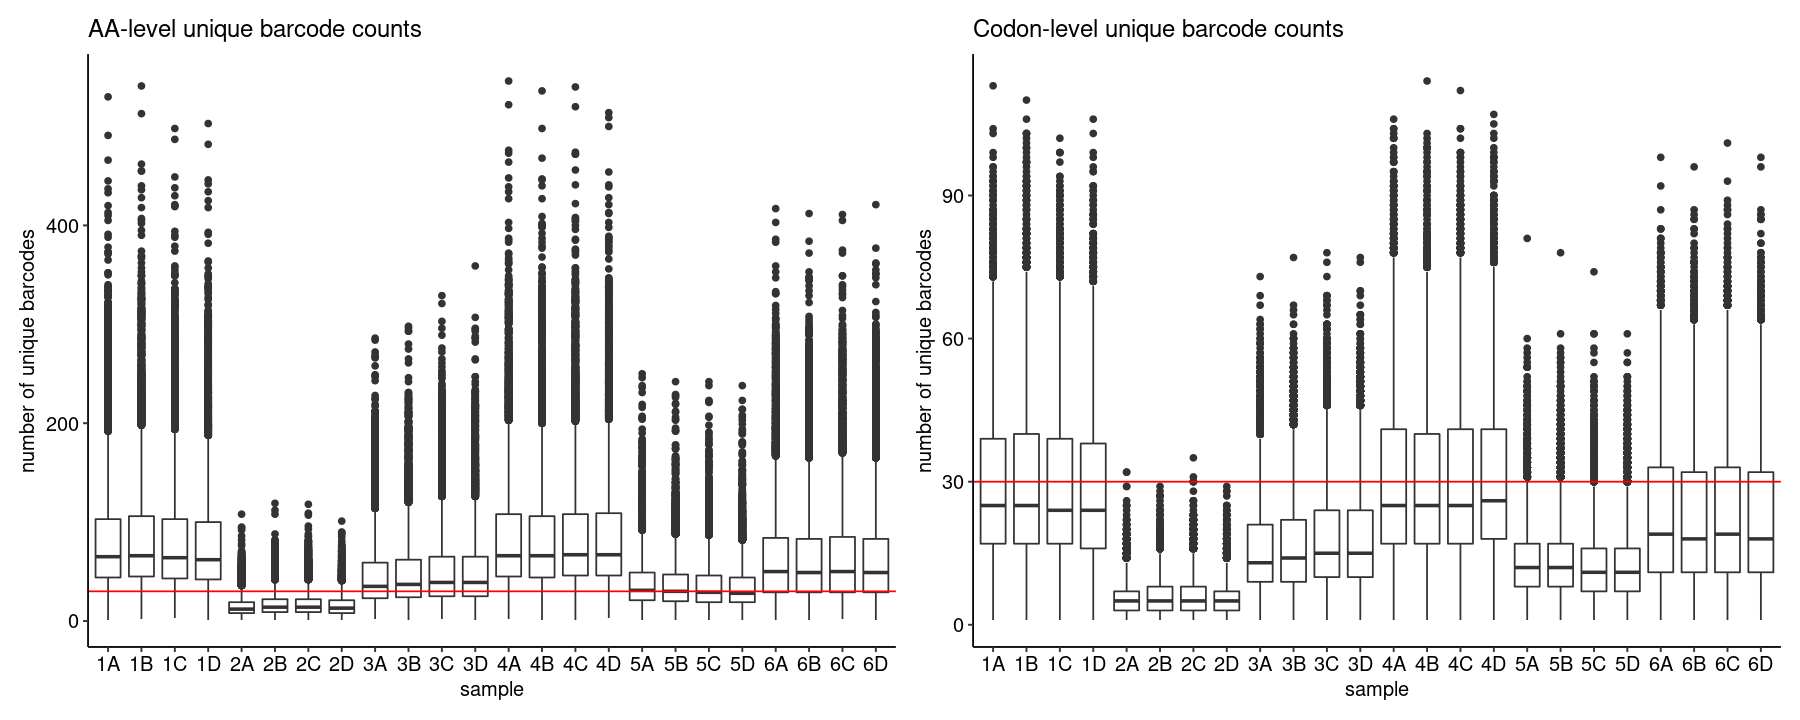

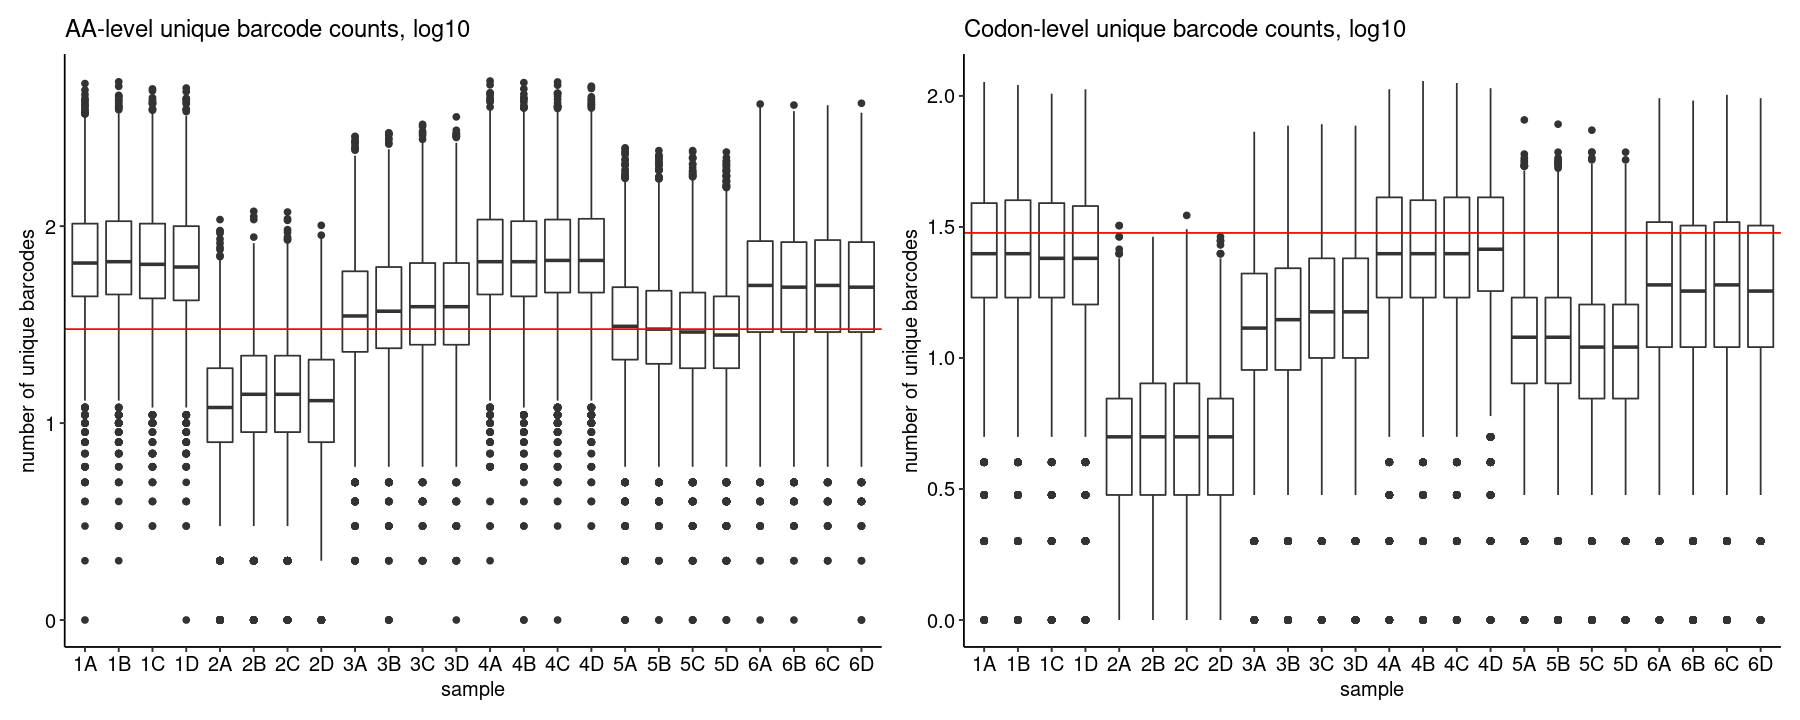

In [6]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

### Statistical Models of Chaperone Rescue <a name="part2"></a>

We could extract many different comparisons from these data. A good starting point is to normalize each of None and aMSH to Forskolin within each Ipsen group (so normalize aMSH-Ipsen to Forskolin-Ipsen, and so on). This corresponds to our previous normalization comparisons (though the aMSH concentration is very different), and we can plot the distribution of stop effects per chunk as before:

In [3]:
sumstats <- dir_ls(path = "../sumstats/MC4R/DMS11/", regexp = "mc4r-cre-chap.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term)) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/mc4r/mc4r-wt-prot.tsv") %>%
    select(WT_AA_Short, Pos) %>%
    rename("pos" = "Pos", "wt_aa" = "WT_AA_Short")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:332

Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sumstats_all <- bind_rows(
    compute_difference("aMSH-Ipsen1e-06", "Forsk-Ipsen2.5e-05", sumstats),
    compute_difference("None-Ipsen0", "Forsk-Ipsen2.5e-05", sumstats),
    compute_difference("aMSH1e-06", "Forsk2.5e-05", sumstats),
    compute_difference("None0", "Forsk2.5e-05", sumstats)
) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           ipsen = if_else(grepl("Ipsen", condition), "Ipsen", "NoIpsen"),
           aMSH = if_else(grepl("aMSH", condition), "aMSH, 1e-06", "None"))

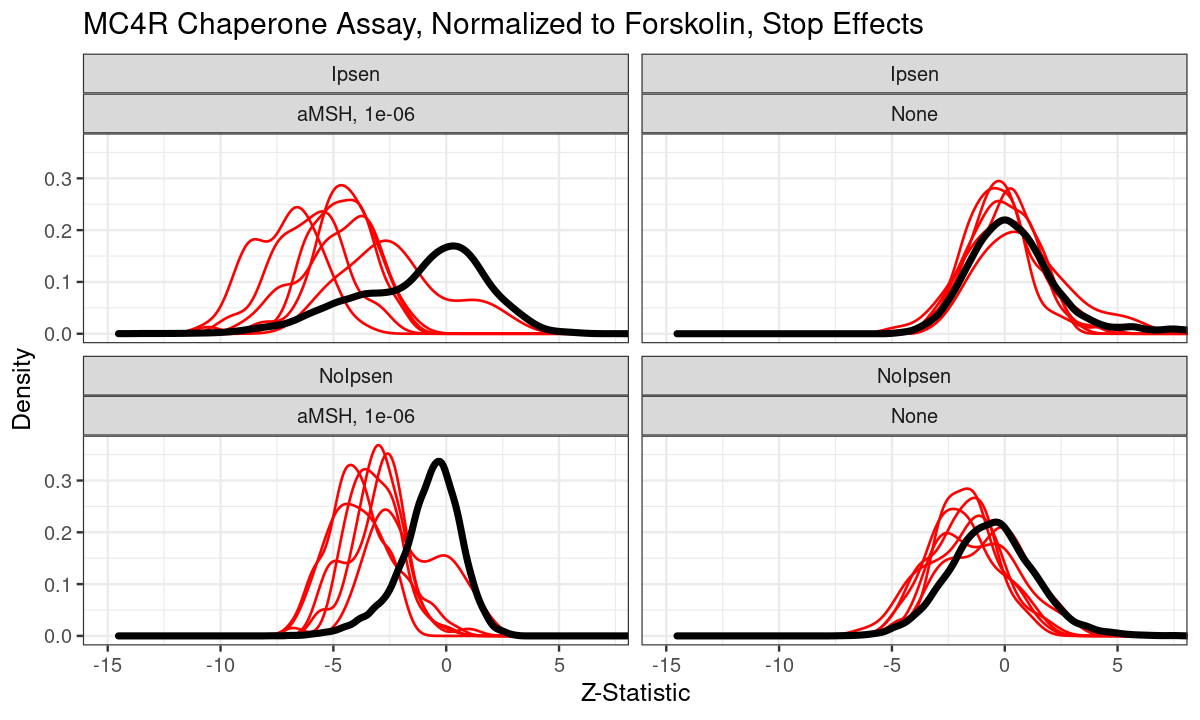

In [5]:
options(repr.plot.width = 10, repr.plot.height = 6)
sumstats_all %>% 
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~ipsen + aMSH, ncol = 2) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("MC4R Chaperone Assay, Normalized to Forskolin, Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can directly plot the Z-statistics of aMSH with Ipsen (normalized to Forskolin) versus the Z-statistic of aMSH without Ipsen (normalized to Forskolin without Ipsen) from the above densities, separating out stops and non-stops:

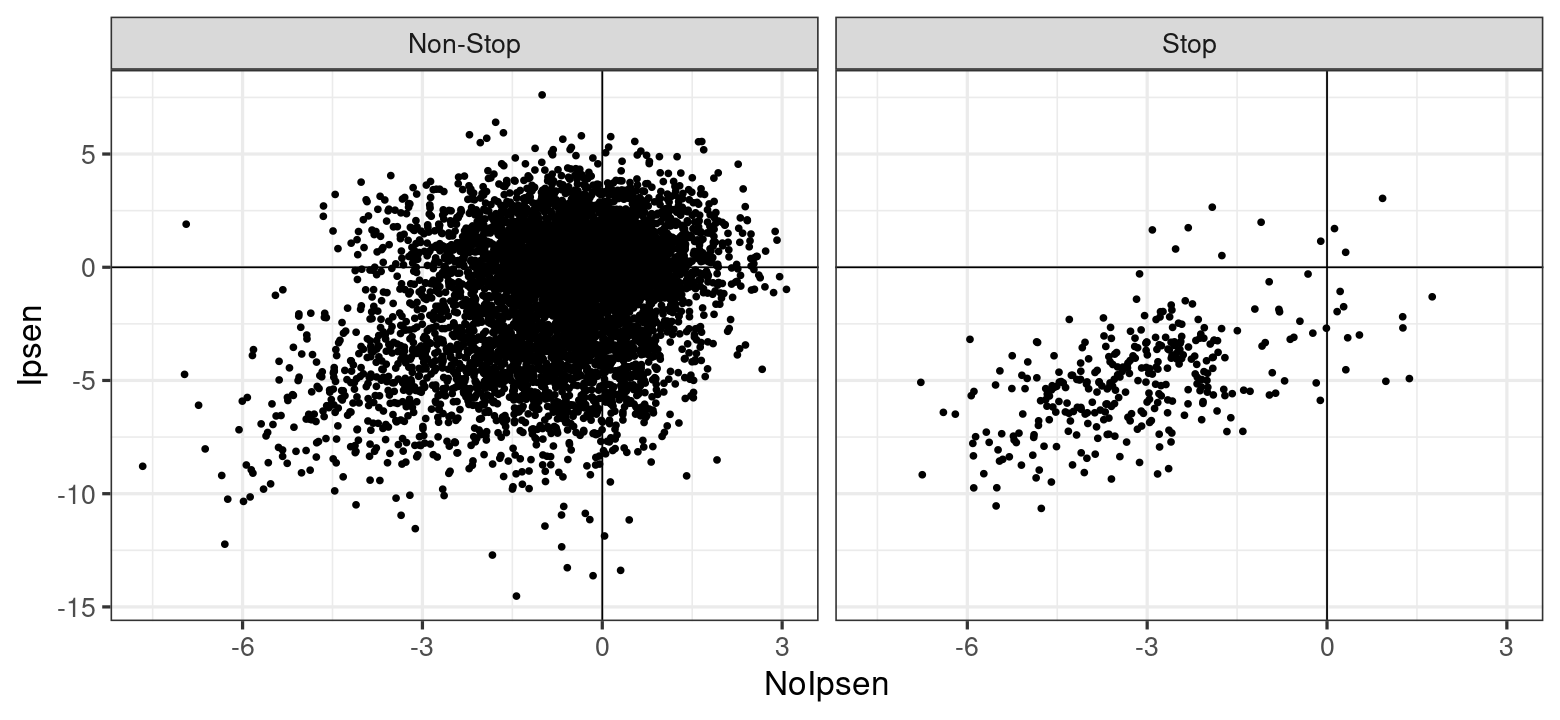

In [6]:
options(repr.plot.width = 13, repr.plot.height = 6)
sumstats_all %>%
    select(aMSH, ipsen, pos, aa, statistic) %>%
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    filter(aMSH == "aMSH, 1e-06") %>%
    pivot_wider(names_from = ipsen, values_from = statistic) %>%
    ggplot() + 
        geom_point(aes(x = NoIpsen, y = Ipsen)) +
        theme_bw(base_size = 20) +
        facet_wrap(~group) +
        geom_vline(xintercept = 0) + geom_hline(yintercept = 0)
        

This is easier to interpret if we color each point by the direction of the difference between Ipsen and No Ipsen effects. In this plot, the gold points are those where the mutant is higher activity than WT in aMSH+Ipsen, but lower than WT in aMSH alone:

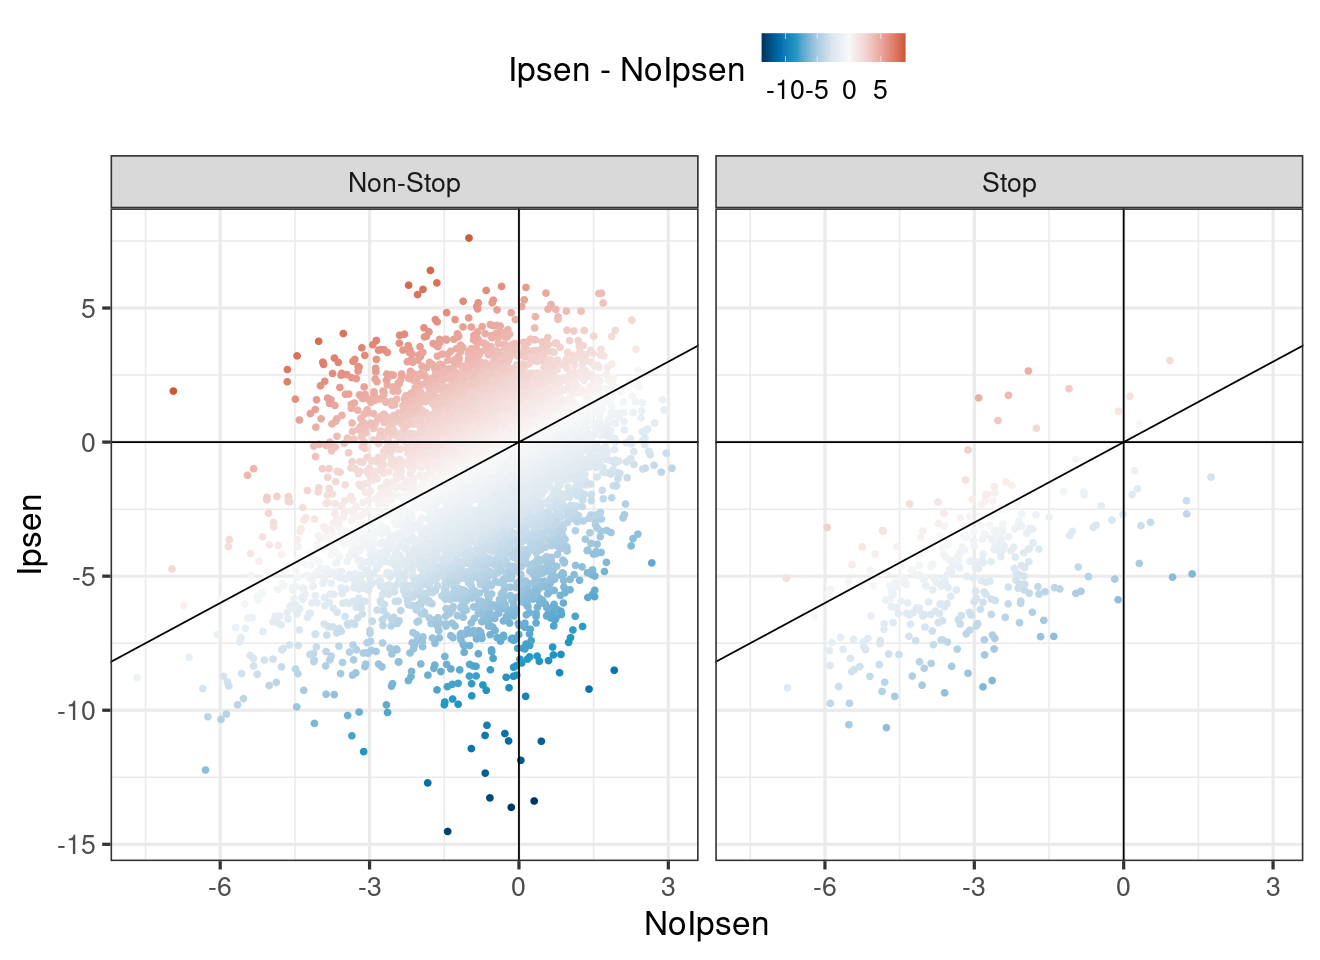

In [7]:
options(repr.plot.width = 11, repr.plot.height = 8)
sumstats_all %>%
    select(aMSH, ipsen, pos, aa, statistic) %>%
    filter(aMSH == "aMSH, 1e-06") %>%
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    pivot_wider(names_from = ipsen, values_from = statistic) %>%
    ggplot() + 
        geom_point(aes(x = NoIpsen, y = Ipsen, color = Ipsen - NoIpsen)) +
        theme_bw(base_size = 20) +
        scale_color_continuous_divergingx(palette = "RdBu", mid = 0, rev = TRUE) +
        geom_abline(intercept = 0, slope = 1) +
        facet_wrap(~group) +
        theme(legend.pos = "top") +
        geom_vline(xintercept = 0) + geom_hline(yintercept = 0)

Stops are generally a bit _more_ negative in Ipsen compared to NoIpsen. However, we will be mostly interested in identifying variants which are on the other end of the distribution. We can summarize the number that are significant in either direction:

In [8]:
sumstats_all_meta <- compute_difference("aMSH-Ipsen1e-06 - Forsk-Ipsen2.5e-05",
                                        "aMSH1e-06 - Forsk2.5e-05",
                                        sumstats_all) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           ipsen = if_else(grepl("Ipsen", condition), "Ipsen", "NoIpsen"),
           aMSH = if_else(grepl("aMSH", condition), "aMSH, 1e-06", "None"))

In [9]:
sumstats_all_meta %>% 
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    mutate("significant" = if_else(p.adj < 0.01, "Significant", "NonSignificant"),
           "direction" = if_else(estimate > 0,"More Active With Ipsen", "Less Active With Ipsen")) %>%
    count(group, significant, direction) %>%
    pivot_wider(names_from = significant, values_from = n) %>% 
    arrange(Significant) %>%
    kable("markdown")



|group    |direction              | NonSignificant| Significant|
|:--------|:----------------------|--------------:|-----------:|
|Stop     |More Active With Ipsen |             47|           1|
|Stop     |Less Active With Ipsen |            256|          27|
|Non-Stop |More Active With Ipsen |           2805|         149|
|Non-Stop |Less Active With Ipsen |           2836|         512|

### Visualizations <a name="part3"></a>

To better understand what these comparisons are doing, we can generate both the heatmaps for each aMSH condition separately, and then show the heatmap of the difference which corresponds to the comparison shown above. First, we show the aMSH and aMSH + Ipsen heatmaps (both normalized to their respective Forskolin):

In [16]:
norm_heatmap_l2fc <- sumstats_all %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    filter(grepl("aMSH", condition)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = estimate)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1)

norm_heatmap_z <- sumstats_all %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    filter(grepl("aMSH", condition)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1)

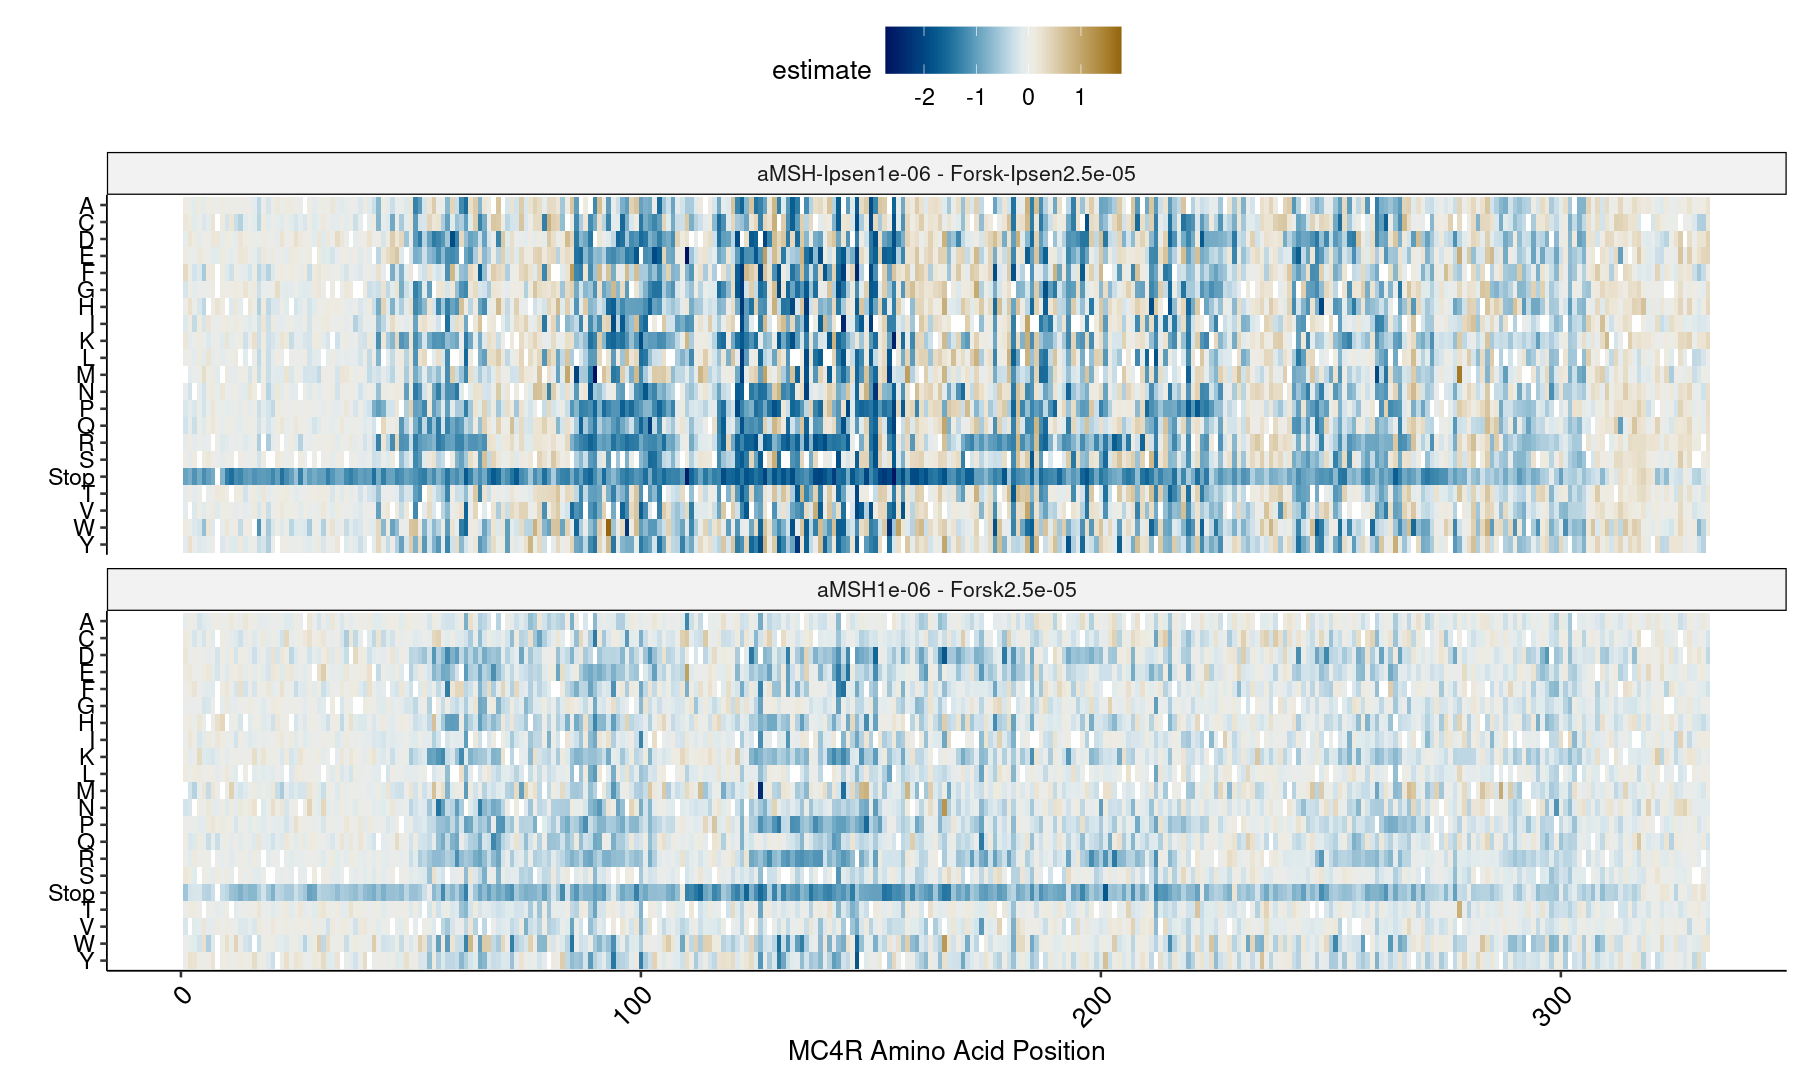

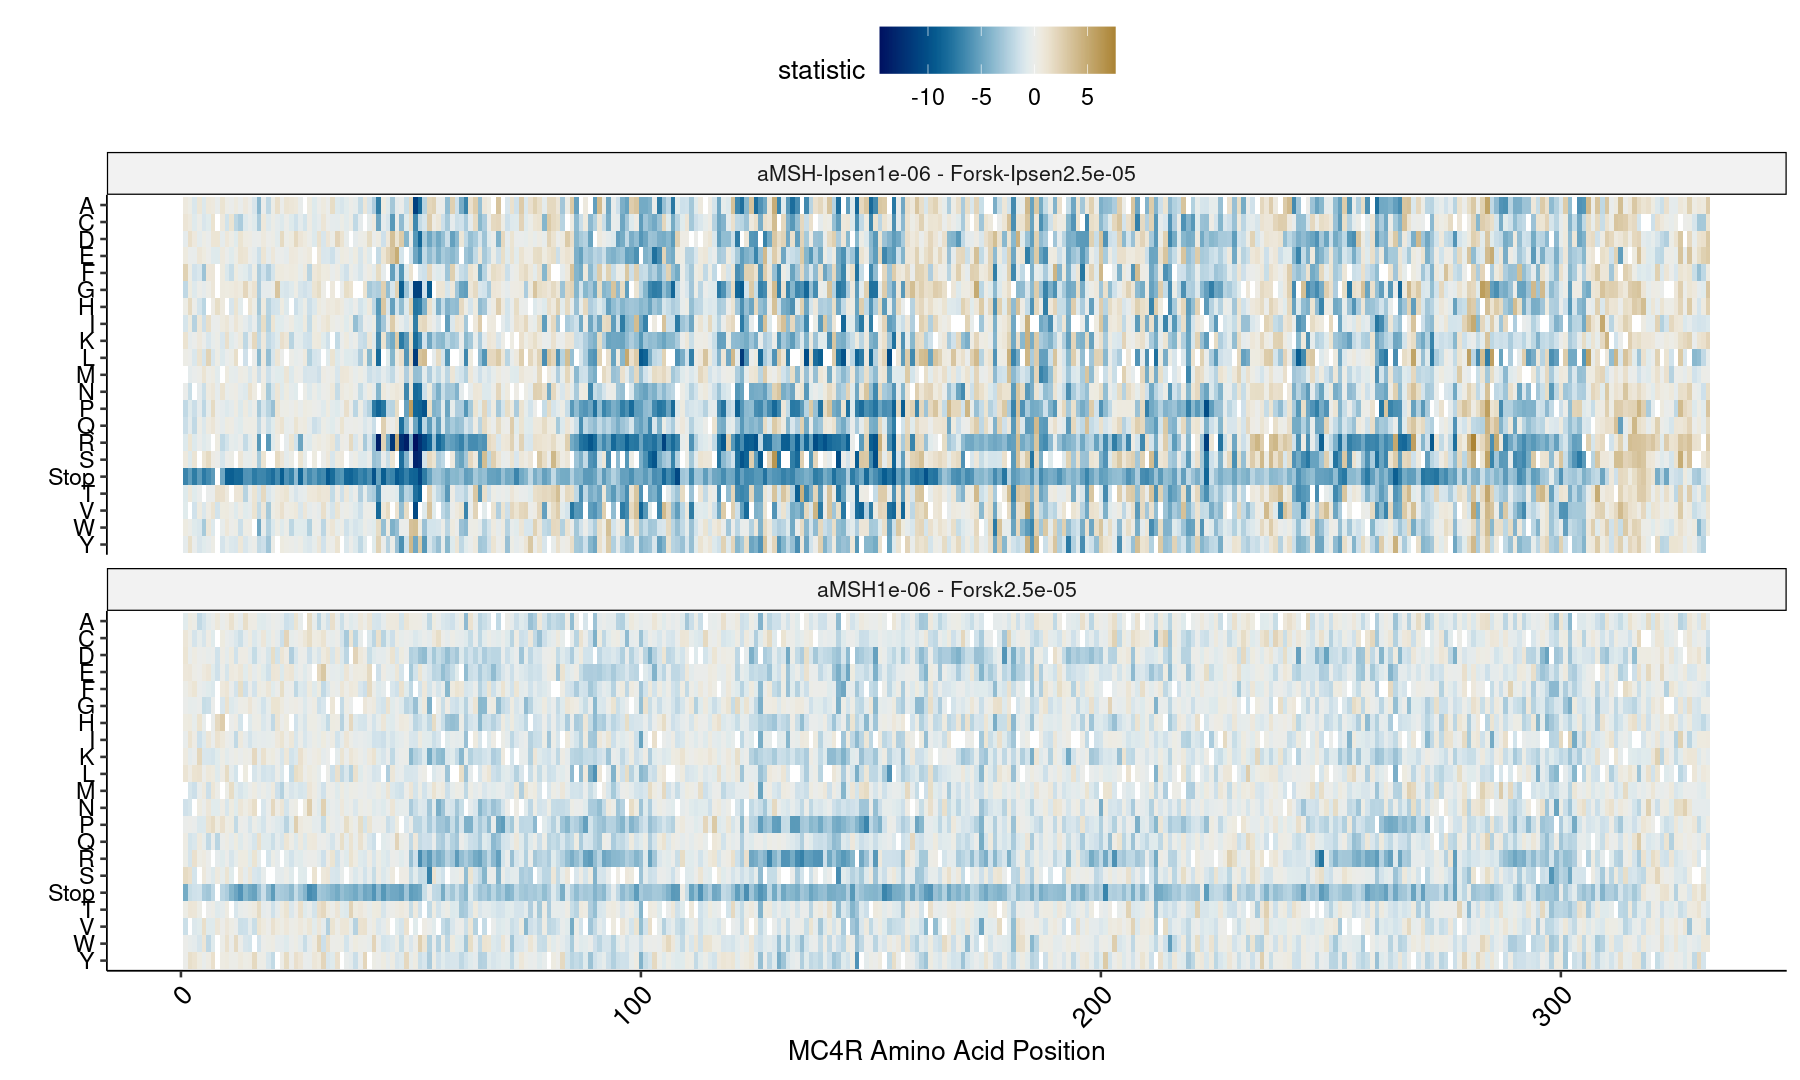

In [17]:
options(repr.plot.width = 15, repr.plot.height = 9)
norm_heatmap_l2fc
norm_heatmap_z
ggsave("../dataviz/MC4R/MC4R-GsChap-L2FC.pdf", norm_heatmap_l2fc, width = 15, height = 9)
ggsave("../dataviz/MC4R/MC4R-GsChap-Z.pdf", norm_heatmap_z, width = 15, height = 9)

Then, we can compute the heatmap representing the difference between the two aMSH heatmaps above:

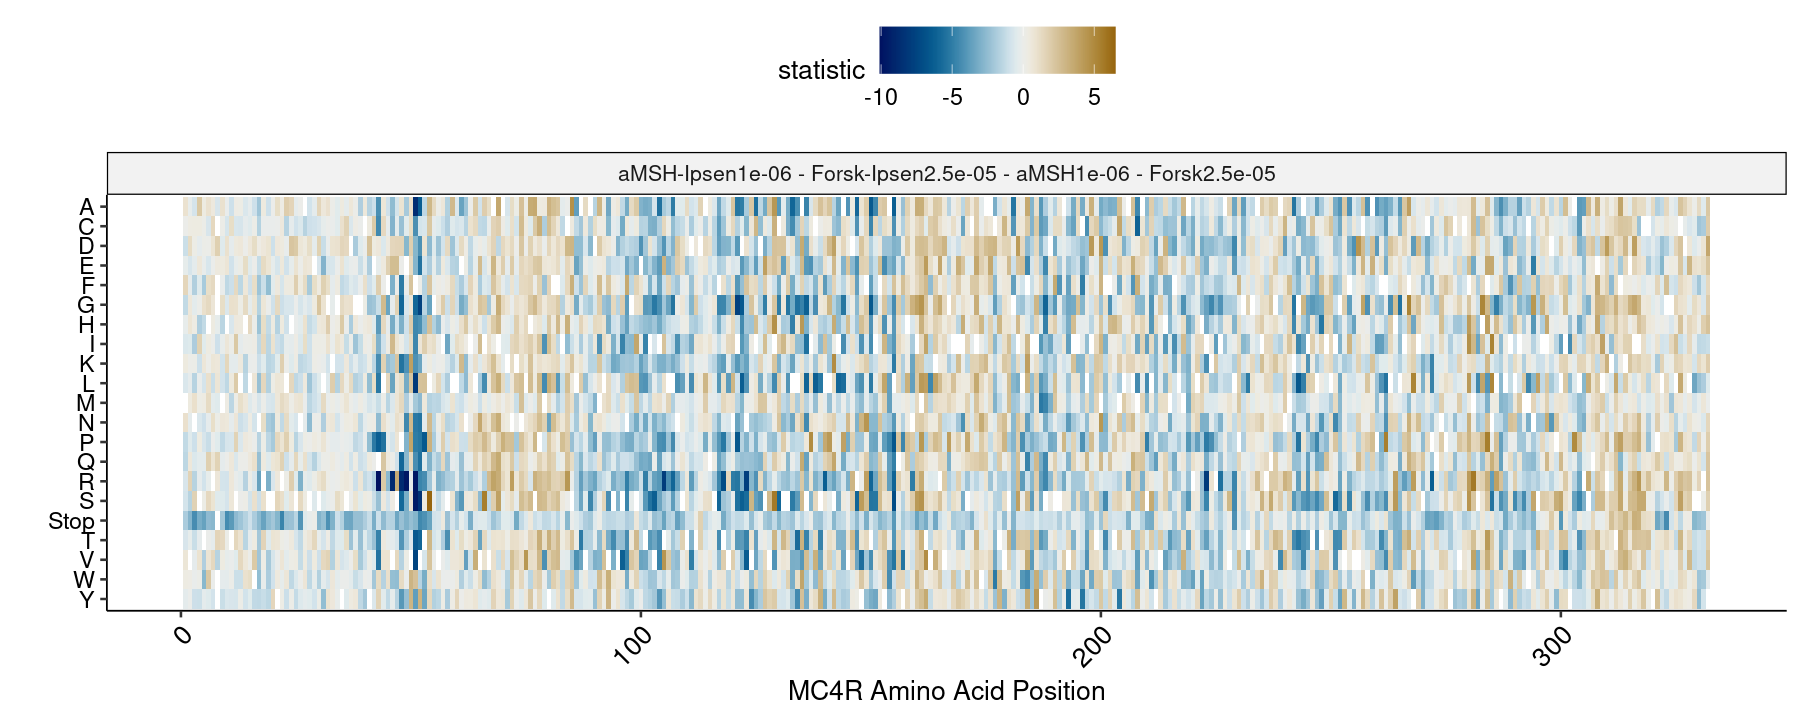

In [188]:
options(repr.plot.width = 15, repr.plot.height = 6)
sumstats_all_meta %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1)

And equivalently, represent the results as a volcano plot using the log2FoldChange and the unadjusted p-values:

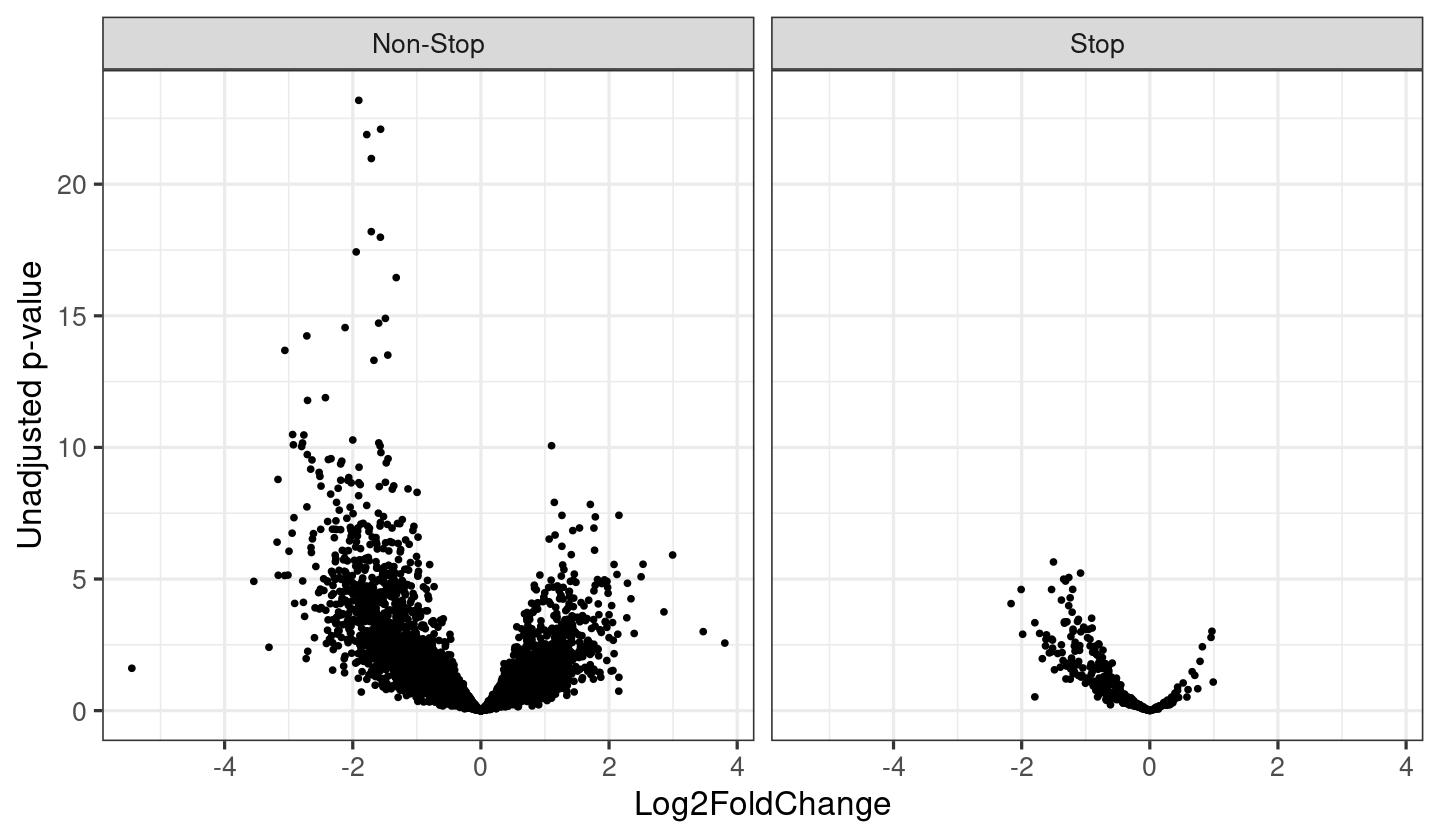

In [191]:
options(repr.plot.width = 12, repr.plot.height = 7)
sumstats_all_meta %>%
    mutate(group = if_else(aa == "*", "Stop", "Non-Stop")) %>%
    ggplot() +
        geom_point(aes(x = estimate/log(2), y = -log10(p.value))) +
        theme_bw(base_size = 20) +
        xlab("Log2FoldChange") + ylab("Unadjusted p-value") +
        facet_wrap(~group)

The resulting significant, positive variant set excluding stops contains 149 variants, which we can summarize:

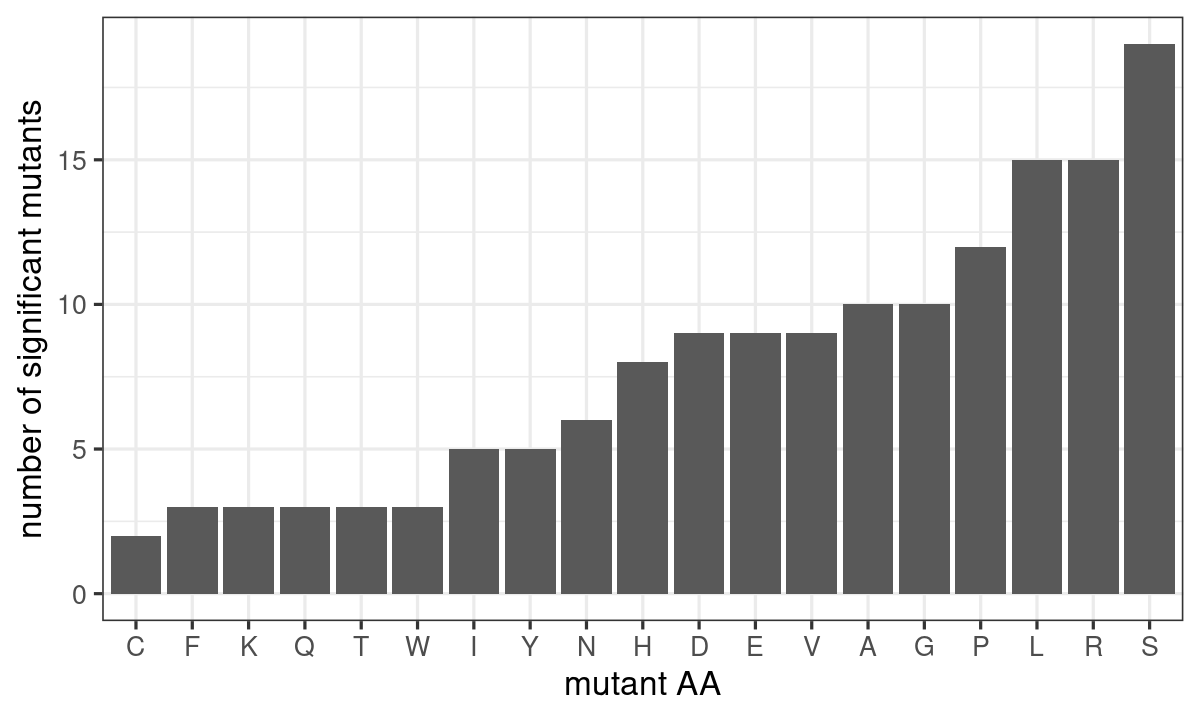

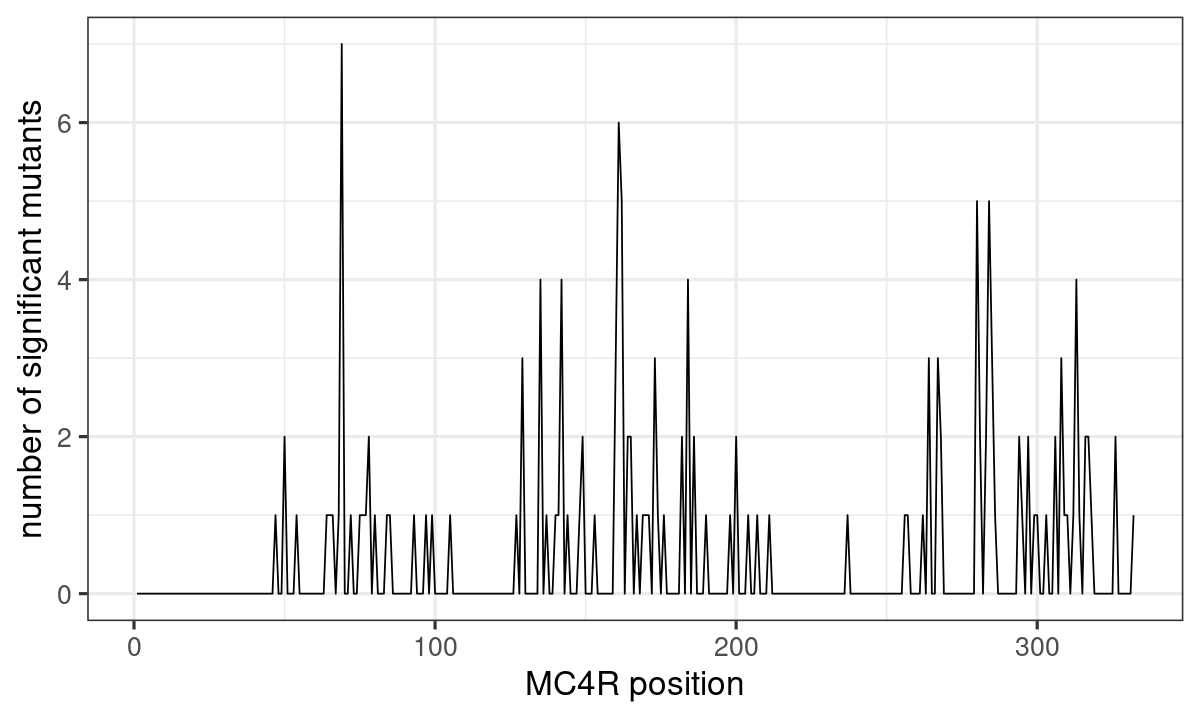

In [212]:
options(repr.plot.width = 10, repr.plot.height = 6)

sumstats_all_meta_sigpos <- sumstats_all_meta %>% filter(estimate > 0, p.adj < 0.01, aa != "*") 
zeros <- tibble("n" = 0, "pos" = 1:332) %>% filter(!pos %in% sumstats_all_meta_sigpos$pos)

sumstats_all_meta_sigpos %>%
    count(aa) %>%
    ggplot() +
        geom_bar(aes(x = reorder(aa, n), y = n), stat = "identity") +
        theme_bw(base_size = 20) +
        ylab("number of significant mutants") + xlab("mutant AA")

sumstats_all_meta_sigpos %>%
    count(pos) %>%
    bind_rows(zeros) %>%
    ggplot() +
        geom_line(aes(x = pos, y = n)) +
        theme_bw(base_size = 20) +
        ylab("number of significant mutants") + xlab("MC4R position")

In [216]:
sumstats_all_meta_sigpos %>%
    count(pos) %>%
    arrange(-n) %>%
    head() %>%
    kable("markdown")

sumstats_all_meta_sigpos %>%
    count(aa) %>%
    arrange(-n) %>%
    head() %>%
    kable("markdown")



| pos|  n|
|---:|--:|
|  69|  7|
| 161|  6|
| 162|  5|
| 280|  5|
| 284|  5|
| 135|  4|



|aa |  n|
|:--|--:|
|S  | 19|
|L  | 15|
|R  | 15|
|P  | 12|
|A  | 10|
|G  | 10|

### The "None" Condition <a name="part4"></a>

The None condition is a bit strange, since for the main question described in the previous section we do not really need it. However, it is worth mentioning that there was a very unusual and striking pattern in the None data when normalized to Forskolin:

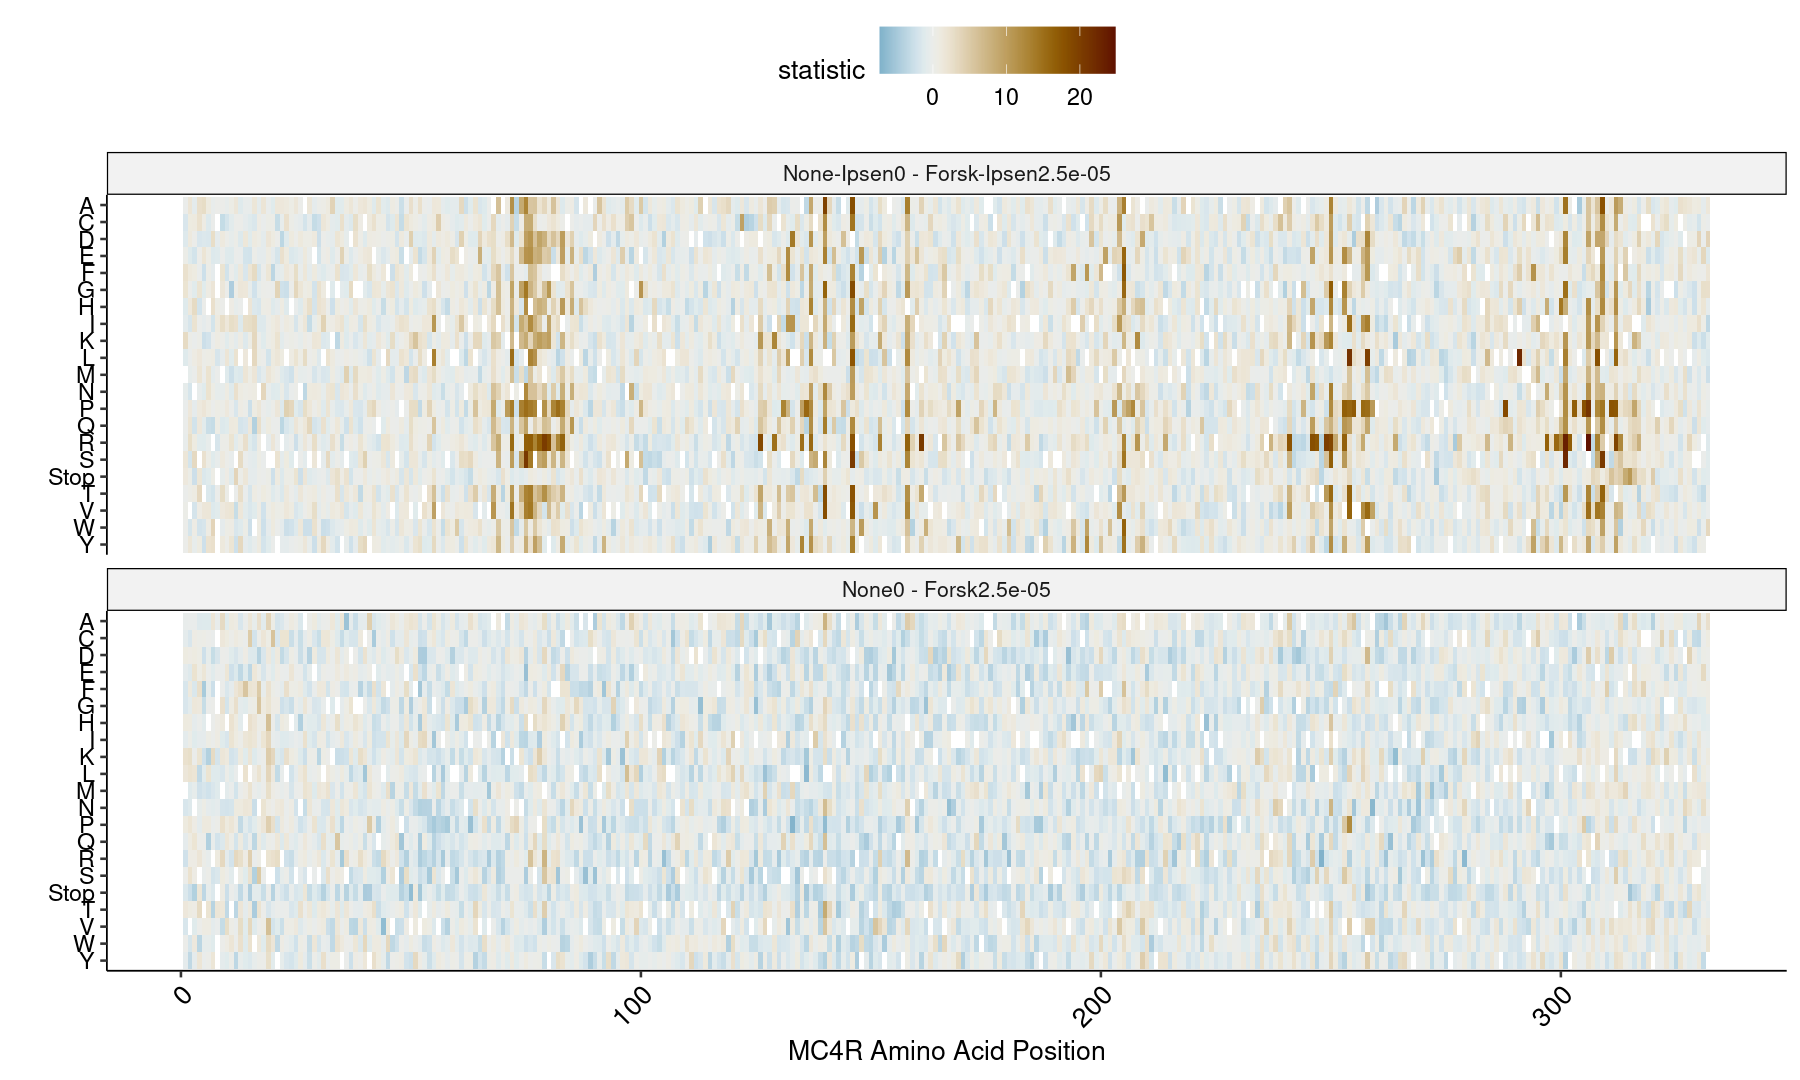

In [217]:
options(repr.plot.width = 15, repr.plot.height = 9)
sumstats_all %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    filter(!grepl("aMSH", condition)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1)

There appears to be very little basal activity, but that is only because the overwhelming signal from the Ipsen-treated sample is pushing the scale up. We can regenerate these with a more constrained scale:

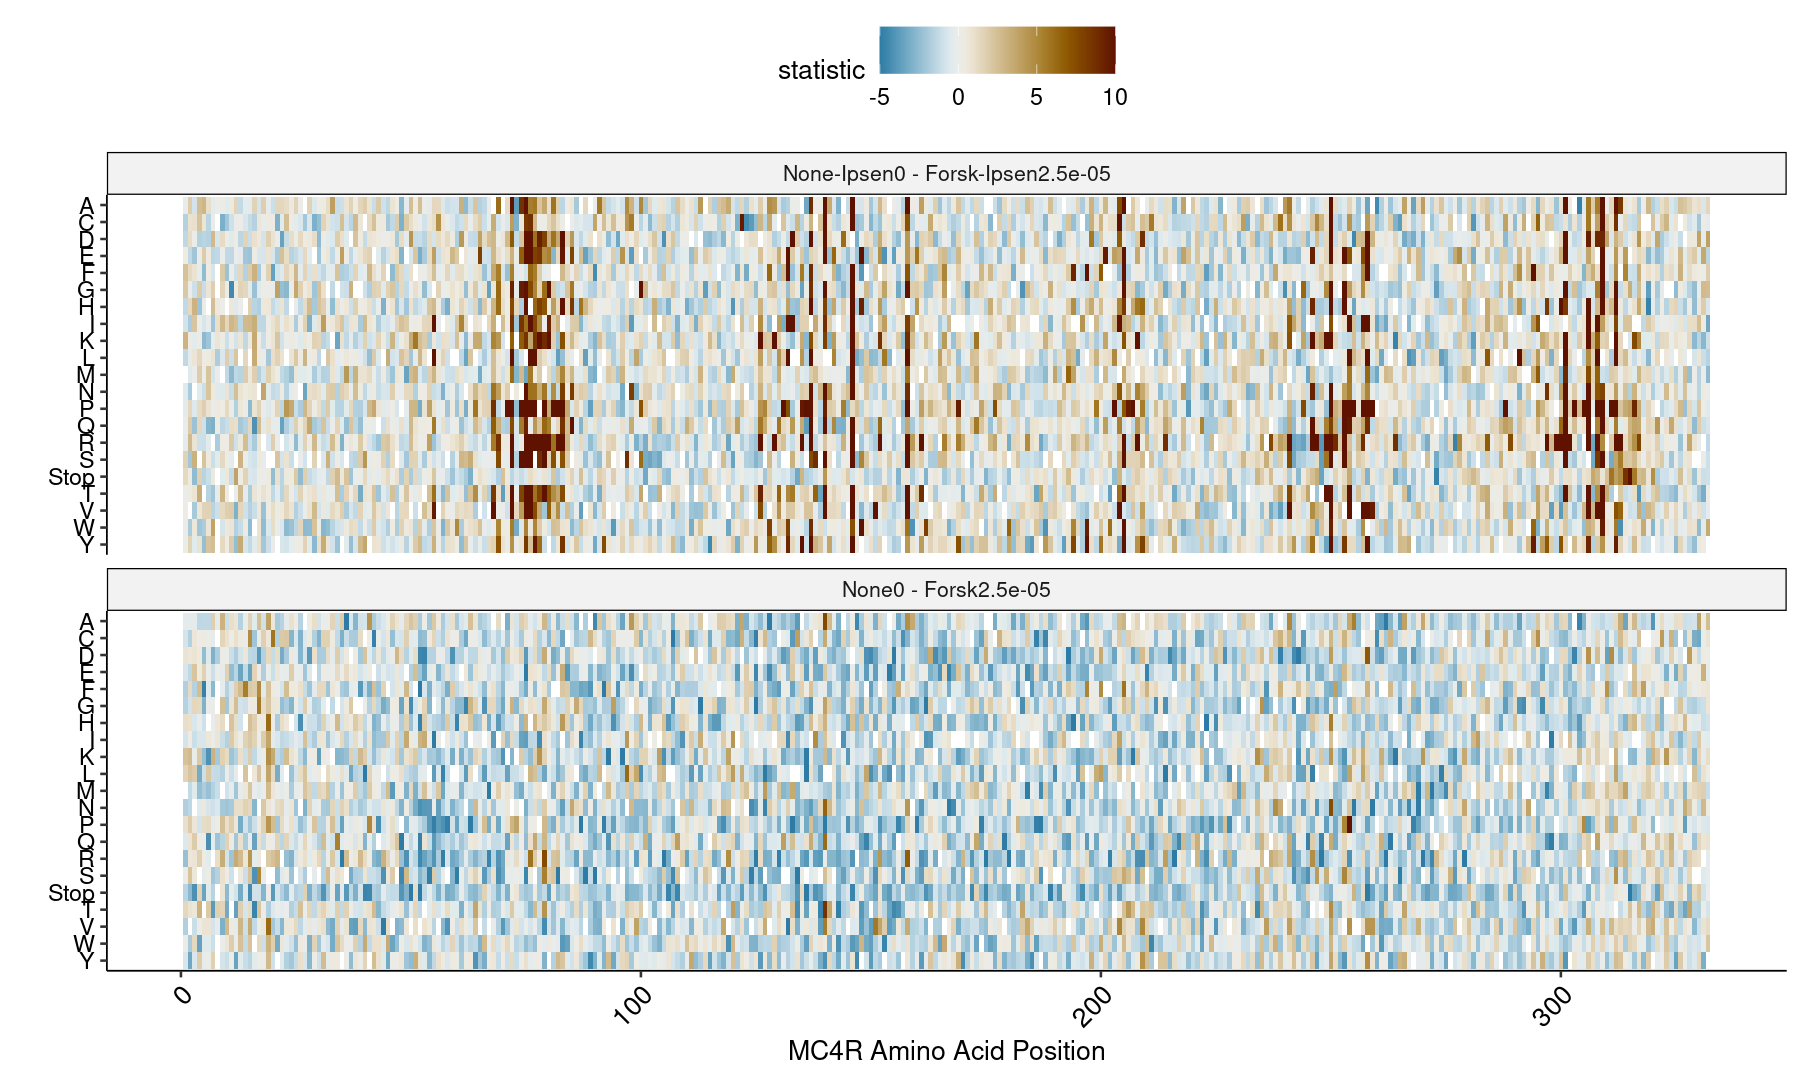

In [219]:
options(repr.plot.width = 15, repr.plot.height = 9)
sumstats_all %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    filter(!grepl("aMSH", condition)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(limits = c(-5, 10), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1)

Even with this adjustment, there is a very clear variant set which is strongly activated (their activity becomes significantly higher than WT) upon Ipsen treatment, in the absence of any aMSH. Separately, basal activity in the lower panel is somewhat visible but much weaker than in the Gs/DMS5 assay.